# CMS Open Data Tutorial

## First COMETA workshop on artificial intelligence for multi-boson physics
## NIKHEF 2-3 Oct 2024

What we cover here:

* What's available from CMS on the open data portal and how to find it
* The `cernopendata-client` and how to use it
* What's in the CMS NANOAOD format and how to use it

## CMS Open Data

Before we do anything let's go to the [CERN Open Data Portal](https://opendata.cern.ch/) and discover what open data and resources are available.

## Accessing data: the `cernopendata-client`

The [cernopendata-client](https://cernopendata-client.readthedocs.io/en/latest/) is a useful command line tool for accessing data in the CERN Open Data Portal. 


In a terminal in your virtual environment you can install it with the following command:
```
pip install cernopendata-client
```

We'll use it here in the notebook using the command line prompt `!`

Let's run the command with the help option:

In [1]:
!cernopendata-client --help

Usage: cernopendata-client [OPTIONS] COMMAND [ARGS]...

  Command-line client for interacting with CERN Open Data portal.

Options:
  --help  Show this message and exit.

Commands:
  download-files      Download data files belonging to a record.
  get-file-locations  Get a list of data file locations of a record.
  get-metadata        Get metadata content of a record.
  list-directory      List contents of a EOSPUBLIC Open Data directory.
  verify-files        Verify downloaded data file integrity.
  version             Return cernopendata-client version.


Recall that each CMS dataset is associated to a record on the CODP. Let's select a QCD NANOAODSIM dataset:

[Simulated dataset QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8 in NANOAODSIM format for 2016 collision data](https://opendata.cern.ch/record/63168)

which is record number 63168.

With the CLI we can list the metadata for this dataset:

In [3]:
!cernopendata-client get-metadata --recid 63168

{
    "$schema": "http://opendata.cern.ch/schema/records/record-v1.0.0.json",
    "_bucket": "5d4b6d5f-a82c-4654-980d-7d8d7978b1b2",
    "abstract": {
        "description": "<p>Simulated dataset QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8 in NANOAODSIM format for 2016 collision data.</p><p>See the description of the simulated dataset names in: <a href=\"/about/CMS-Simulated-Dataset-Names\">About CMS simulated dataset names</a>.</p><p>These simulated datasets correspond to the collision data collected by the CMS experiment in 2016.</p>"
    },
    "accelerator": "CERN-LHC",
    "categories": {
        "primary": "Standard Model Physics",
        "secondary": [
            "QCD"
        ],
        "source": "CMS Collaboration"
    },
    "collaboration": {
        "name": "CMS Collaboration"
    },
    "collections": [
        "CMS-Simulated-Datasets"
    ],
    "collision_information": {
        "energy": "13TeV",
        "type": "pp"
    },
    "control_number": "63168",
    "datas

Let's list the files available in this record:

In [4]:
!cernopendata-client get-file-locations --recid 63168 --verbose

http://opendata.cern.ch/eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/1C569D85-60AE-7D43-B42B-6D6FD1D66CC7.root	2761359192	adler32:1b3c3628
http://opendata.cern.ch/eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/2EDCC683-1B4B-614B-BEB7-D80BBC20AD8E.root	804633059	adler32:5ff6eb2b
http://opendata.cern.ch/eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/19E8D842-3175-1449-AF6C-FD9C69D12724.root	54891248	adler32:434582cb
http://opendata.cern.ch/eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/3957434B-7E09-3B4C-8329-FD44D82C7DB7.root	148144417	adler32:978c9539
http://opendata.cern.ch/eos/opendata/cms/mc/RunIISummer20UL1

By default the files are given with the HTTP protocol. If you wish to use XRootD: 

In [5]:
!cernopendata-client get-file-locations --recid 63168 --protocol xrootd --verbose

root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/1C569D85-60AE-7D43-B42B-6D6FD1D66CC7.root	2761359192	adler32:1b3c3628
root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/130000/2EDCC683-1B4B-614B-BEB7-D80BBC20AD8E.root	804633059	adler32:5ff6eb2b
root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/19E8D842-3175-1449-AF6C-FD9C69D12724.root	54891248	adler32:434582cb
root://eospublic.cern.ch//eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/3957434B-7E09-3B4C-8329-FD44D82C7DB7.root	148144417	adler32:978c9539
root://eospublic.cern.ch//eos/opendata/cms/mc/RunIIS

Now let's download a file, one of the smaller ones. Note that the `cernopendata-client` has a download files option but since we know which file we want well use `curl` instead.

In [6]:
!cernopendata-client download-files --help

Usage: cernopendata-client download-files [OPTIONS]

  Download data files belonging to a record.

  Select a CERN Open Data bibliographic record by a record ID, a DOI, or a
  title and download data files belonging to this record.

  Examples:

       $ cernopendata-client download-files --recid 5500

       $ cernopendata-client download-files --recid 5500 --filter-name
       BuildFile.xml

       $ cernopendata-client download-files --recid 5500 --filter-regexp py$

       $ cernopendata-client download-files --recid 5500 --filter-range 1-4

       $ cernopendata-client download-files --recid 5500 --filter-range
       1-2,5-7

       $ cernopendata-client download-files --recid 5500 --filter-regexp py
       --filter-range 1-2

Options:
  --recid INTEGER                 Record ID
  --doi TEXT                      Digital Object Identifier
  --title TEXT                    Record title
  --protocol [http|xrootd]        Protocol to be used in links [http,xrootd]
  --expand / --no-ex

In [7]:
!curl -O http://opendata.cern.ch/eos/opendata/cms/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/270000/397D1673-167A-CF46-9E79-D7069D9AC359.root

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6262k  100 6262k    0     0  3946k      0  0:00:01  0:00:01 --:--:-- 3946k


## Exploring the data: the CMS NANOAOD format

The NANOAOD files can of course be opened and explored using ROOT, in particular [PyROOT](https://root.cern/manual/python/). Here we'll instead use the SciKit-HEP tools [uproot](https://github.com/scikit-hep/uproot5) ("ROOT I/O in pure Python and NumPy") and [awkward](https://github.com/scikit-hep/awkward) ("Manipulate JSON-like data with NumPy-like idioms").

In [2]:
import numpy as np
import matplotlib.pylab as plt

import uproot
import awkward as ak

ModuleNotFoundError: No module named 'uproot'

Let's first open the file we've downloaded and see what's in it:

In [9]:
infile_name = '397D1673-167A-CF46-9E79-D7069D9AC359.root'
infile = uproot.open(infile_name)

keys = infile.keys()
print(keys)

['tag;1', 'Events;1', 'LuminosityBlocks;1', 'Runs;1', 'MetaData;1', 'ParameterSets;1']


If you were using ROOT and opened up the file with a `TBrowser` you would see something like this:

![nanoaod in the tbrowser](imgs/nano-root.png)

In [10]:
events = infile['Events']
events.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | uint32_t                 | AsDtype('>u4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
HTXS_Higgs_pt        | float                    | AsDtype('>f4')
HTXS_Higgs_y         | float                    | AsDtype('>f4')
HTXS_stage1_1_cat... | int32_t                  | AsDtype('>i4')
HTXS_stage1_1_cat... | int32_t                  | AsDtype('>i4')
HTXS_stage1_1_fin... | int32_t                  | AsDtype('>i4')
HTXS_stage1_1_fin... | int32_t                  | AsDtype('>i4')
HTXS_stage1_2_cat... | int32_t                  | AsDtype('>i4')
HTXS_stage1_2_cat... | int32_t                  | AsDtype('>i4')
HTXS_stage1_2_fin... | int32_t                  | AsDtype('>i4')
HTXS_stage1_2_fin... | int32_t                  | AsDtype(

In [11]:
events.keys()

['run',
 'luminosityBlock',
 'event',
 'HTXS_Higgs_pt',
 'HTXS_Higgs_y',
 'HTXS_stage1_1_cat_pTjet25GeV',
 'HTXS_stage1_1_cat_pTjet30GeV',
 'HTXS_stage1_1_fine_cat_pTjet25GeV',
 'HTXS_stage1_1_fine_cat_pTjet30GeV',
 'HTXS_stage1_2_cat_pTjet25GeV',
 'HTXS_stage1_2_cat_pTjet30GeV',
 'HTXS_stage1_2_fine_cat_pTjet25GeV',
 'HTXS_stage1_2_fine_cat_pTjet30GeV',
 'HTXS_stage_0',
 'HTXS_stage_1_pTjet25',
 'HTXS_stage_1_pTjet30',
 'HTXS_njets25',
 'HTXS_njets30',
 'nboostedTau',
 'boostedTau_chargedIso',
 'boostedTau_eta',
 'boostedTau_leadTkDeltaEta',
 'boostedTau_leadTkDeltaPhi',
 'boostedTau_leadTkPtOverTauPt',
 'boostedTau_mass',
 'boostedTau_neutralIso',
 'boostedTau_phi',
 'boostedTau_photonsOutsideSignalCone',
 'boostedTau_pt',
 'boostedTau_puCorr',
 'boostedTau_rawAntiEle2018',
 'boostedTau_rawIso',
 'boostedTau_rawIsodR03',
 'boostedTau_rawMVAnewDM2017v2',
 'boostedTau_rawMVAoldDM2017v2',
 'boostedTau_rawMVAoldDMdR032017v2',
 'boostedTau_charge',
 'boostedTau_decayMode',
 'boostedTau_je

In [12]:
events.values()

[<TBranch 'run' at 0x7594b4141910>,
 <TBranch 'luminosityBlock' at 0x75946c6c35e0>,
 <TBranch 'event' at 0x75946c6c3d90>,
 <TBranch 'HTXS_Higgs_pt' at 0x75946c6c8580>,
 <TBranch 'HTXS_Higgs_y' at 0x75946c6c8d30>,
 <TBranch 'HTXS_stage1_1_cat_pTjet25GeV' at 0x75946c6ce520>,
 <TBranch 'HTXS_stage1_1_cat_pTjet30GeV' at 0x75946c6cecd0>,
 <TBranch 'HTXS_stage1_1_fine_cat_pTjet25GeV' at 0x75946c6d34c0>,
 <TBranch 'HTXS_stage1_1_fine_cat_pTjet30GeV' at 0x75946c6d3c70>,
 <TBranch 'HTXS_stage1_2_cat_pTjet25GeV' at 0x75946c6da460>,
 <TBranch 'HTXS_stage1_2_cat_pTjet30GeV' at 0x75946c6dac10>,
 <TBranch 'HTXS_stage1_2_fine_cat_pTjet25GeV' at 0x75946c6df400>,
 <TBranch 'HTXS_stage1_2_fine_cat_pTjet30GeV' at 0x75946c6dfbb0>,
 <TBranch 'HTXS_stage_0' at 0x75946c6e43d0>,
 <TBranch 'HTXS_stage_1_pTjet25' at 0x75946c6e4b80>,
 <TBranch 'HTXS_stage_1_pTjet30' at 0x75946c66b370>,
 <TBranch 'HTXS_njets25' at 0x75946c66bb20>,
 <TBranch 'HTXS_njets30' at 0x75946c670310>,
 <TBranch 'nboostedTau' at 0x75946c670

What does all this mean? Recall that thankfully in the [dataset record](https://opendata.cern.ch/record/63168) there is a list of file variables (with explanations) under `Dataset semantics`. The link is [here](https://opendata.cern.ch/eos/opendata/cms/dataset-semantics/NanoAODSIM/63168/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8_doc.html).

![nanoaod dataset semantics](imgs/nano-jet.png)

Let's extract and plot some variables:

* jet multiplicity

* jet pt

* jet eta

We'll read them out as `awkward` arrays:

In [13]:
jet_mult = events['Jet_nConstituents'].array()
jet_pt = events['Jet_pt'].array()
jet_eta = events['Jet_eta'].array()

Note the structure of the array, in which each element of array corresponds to an event and the size of each element
depends on the number of jets in the event:

In [14]:
jet_mult

<Array [[14, 5], ..., [46, 45, 40, ..., 9, 16, 17]] type='2000 * var * uint8'>

Note that we have to use `ak.flatten` to flatten the array structure before we create a histogram:

In [15]:
ak.flatten(jet_mult)

<Array [14, 5, 19, 15, 24, 19, ..., 42, 20, 22, 9, 16, 17] type='10532 * uint8'>

Text(0.5, 0, 'jet_eta')

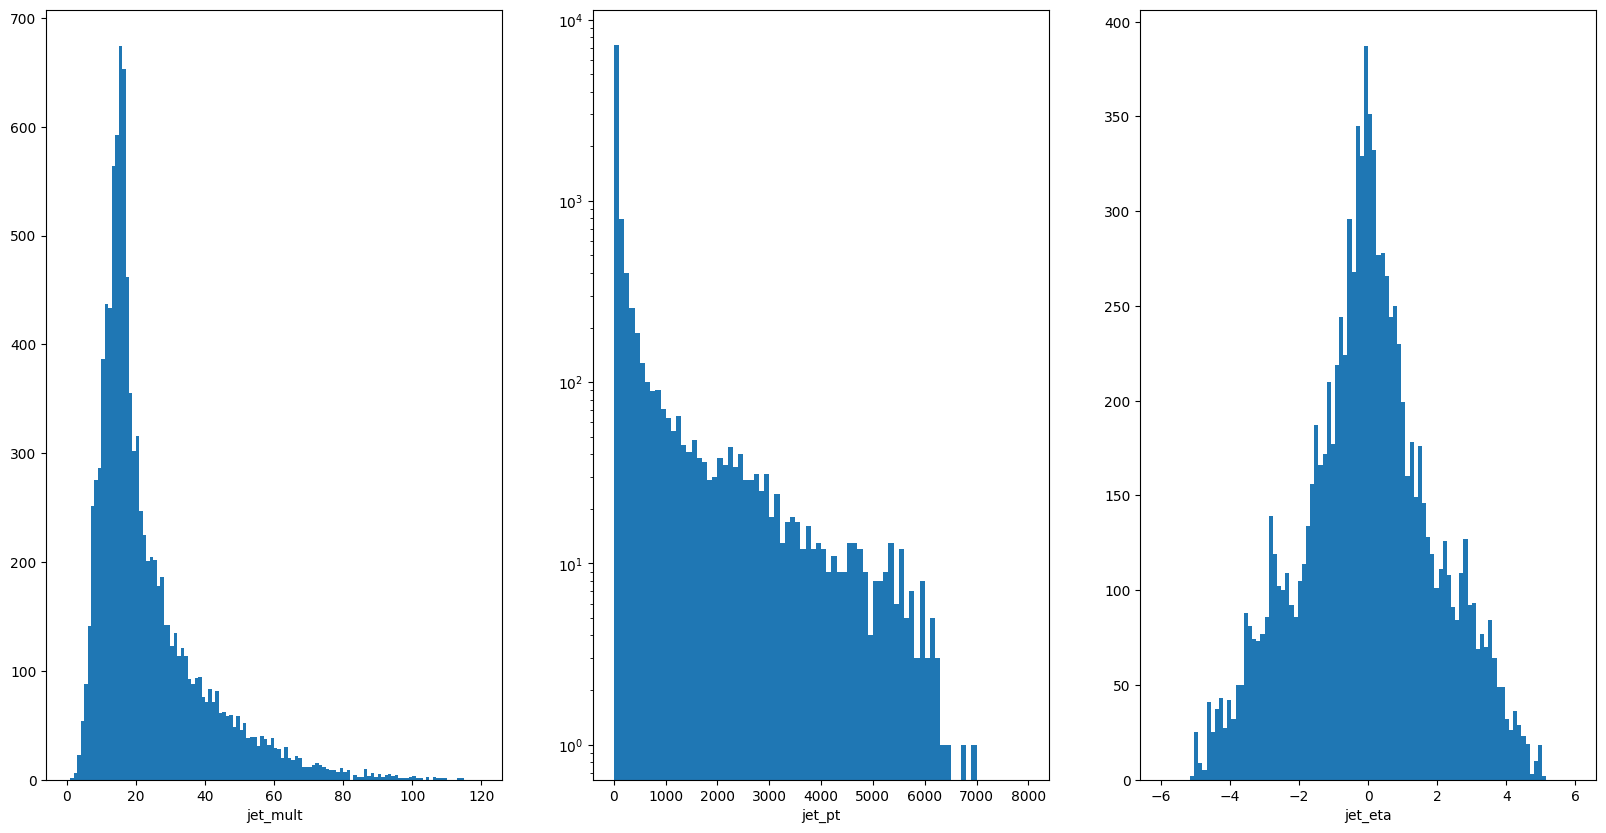

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(20,10))

axes[0].hist(ak.flatten(jet_mult), bins=120, range=(0,120))
axes[0].set_xlabel('jet_mult')

axes[1].hist(ak.flatten(jet_pt), bins=80, range=(0,8000))
axes[1].set_xlabel('jet_pt')
axes[1].set_yscale('log')

axes[2].hist(ak.flatten(jet_eta), bins=100, range=(-6,6))
axes[2].set_xlabel('jet_eta')

It will be convenient to only analyze jet-related variables so let's make a crude selection of `Jet_` keys and collect the objects into a collection of arrays:

In [38]:
jet_keys = [jk for jk in events.keys() if 'Jet_' in jk]
arrays = events.arrays(jet_keys, library="ak")

In [39]:
arrays

<Array [{CorrT1METJet_area: [...], ...}, ...] type='2000 * {CorrT1METJet_ar...'>

For reference, you can also easily convert your collection of arrays into a Pandas DataFrame:

In [40]:
df = events.arrays(jet_keys, library="pd")

In [41]:
df

,CorrT1METJet_area,CorrT1METJet_eta,CorrT1METJet_muonSubtrFactor,CorrT1METJet_phi,CorrT1METJet_rawPt,FatJet_area,FatJet_btagCSVV2,FatJet_btagDDBvLV2,FatJet_btagDDCvBV2,FatJet_btagDDCvLV2,...,L1_Jet32_Mu0_EG10_dPhi_Jet_Mu_Max0p4_dPhi_Mu_EG_Min1p0,L1_TripleJet_84_68_48_VBF,L1_TripleJet_88_72_56_VBF,L1_TripleJet_92_76_64_VBF,HLT_QuadPFJet_BTagCSV_p016_p11_VBF_Mqq200,HLT_QuadPFJet_BTagCSV_p016_VBF_Mqq460,HLT_QuadPFJet_BTagCSV_p016_p11_VBF_Mqq240,HLT_QuadPFJet_BTagCSV_p016_VBF_Mqq500,HLT_QuadPFJet_VBF,HLT_L1_TripleJet_VBF
0,"[0.5087890625, 0.458740234375, 0.48876953125, ...","[-2.89453125, 0.601806640625, -3.6640625, -3.1...","[-7.916241884231567e-09, 8.265487849712372e-09...","[-2.57861328125, 1.421875, -2.029296875, -1.02...","[9.859375, 11.9609375, 13.015625, 11.4765625]",[],[],[],[],[],...,False,False,False,False,False,False,False,False,False,False
1,[0.48876953125],[-1.85009765625],[1.6996636986732483e-08],[-1.44091796875],[8.3828125],[],[],[],[],[],...,False,False,False,False,False,False,False,False,False,False
2,"[0.39892578125, 0.5087890625, 0.52880859375, 0...","[-3.08447265625, -2.0927734375, -0.64721679687...","[1.0244548320770264e-08, 1.3969838619232178e-0...","[-0.930908203125, 3.03515625, -1.3525390625, 2...","[13.3046875, 11.6875, 12.8125, 12.8125, 11.734...",[],[],[],[],[],...,False,False,False,False,False,False,False,False,False,False
3,"[0.52880859375, 0.478759765625, 0.54833984375,...","[2.38818359375, -2.2099609375, 2.34912109375, ...","[2.0721927285194397e-08, 3.119930624961853e-08...","[-1.931396484375, -2.49365234375, -2.812011718...","[8.6484375, 8.1328125, 7.76953125, 7.3671875]",[],[],[],[],[],...,False,False,False,False,False,False,False,False,False,False
4,[0.44873046875],[-2.1455078125],[-2.3050233721733093e-08],[0.37078857421875],[9.7421875],[],[],[],[],[],...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,"[0.37890625, 0.46875, 0.48876953125, 0.6083984...","[0.52294921875, 4.416015625, 3.70703125, -2.91...","[-2.0954757928848267e-08, 1.5425030142068863e-...","[0.42779541015625, -0.7359619140625, 0.0278434...","[16.75, 17.796875, 20.109375, 17.578125, 19.84...","[2.025390625, 1.9951171875]","[0.9404296875, 0.1763916015625]","[0.0005431175231933594, 0.00011080503463745117]","[0.1505126953125, 0.62744140625]","[0.0004258155822753906, 0.00234222412109375]",...,False,True,True,True,False,False,False,False,False,True
1996,"[0.368896484375, 0.498779296875, 0.4189453125,...","[0.5357666015625, -2.951171875, 4.0830078125, ...","[2.468004822731018e-08, -1.4668330550193787e-0...","[2.8544921875, 1.982666015625, -0.83203125, -1...","[14.21875, 12.078125, 13.6328125, 14.3984375]","[1.984375, 1.974609375]","[0.50341796875, 0.93115234375]","[0.00012886524200439453, 0.0003771781921386719]","[0.322021484375, 0.3447265625]","[0.00091552734375, 0.0015697479248046875]",...,False,True,True,True,False,False,False,False,True,True
1997,[],[],[],[],[],"[2.025390625, 2.025390625, 1.875]","[0.30712890625, 0.41552734375, 0.6923828125]","[0.0002703666687011719, 0.0001742839813232422,...","[0.392578125, 0.58935546875, 0.79345703125]","[0.001110076904296875, 0.0016775131225585938, ...",...,True,True,True,True,False,False,False,False,False,True
1998,"[0.57861328125, 0.37890625, 0.46875, 0.4787597...","[0.78564453125, -1.517822265625, -2.3569335937...","[-2.6775524020195007e-08, 1.0360963642597198e-...","[-2.166015625, -1.279541015625, -0.43603515625...","[18.90625, 15.4453125, 14.1171875, 22.515625, ...","[1.96484375, 2.07421875]","[0.75244140625, 0.73876953125]","[0.00020301342010498047, 0.0020656585693359375]","[0.658203125, 0.2344970703125]","[0.00424957275390625, 0.0013608932495117188]",...,False,True,True,True,False,False,False,False,False,True


We'll stick with `awkward` and add selections on G and UDS jets to the arrays so that we can distinguish between them later:

In [42]:
arrays['Jet_isG'] = ak.where(arrays['Jet_partonFlavour'] == 21, True, False)

arrays['Jet_isUDS'] = ak.where(
    (np.abs(arrays['Jet_partonFlavour']) == 1) | (np.abs(arrays['Jet_partonFlavour']) == 2) | (np.abs(arrays['Jet_partonFlavour']) == 3),
    True, False
)

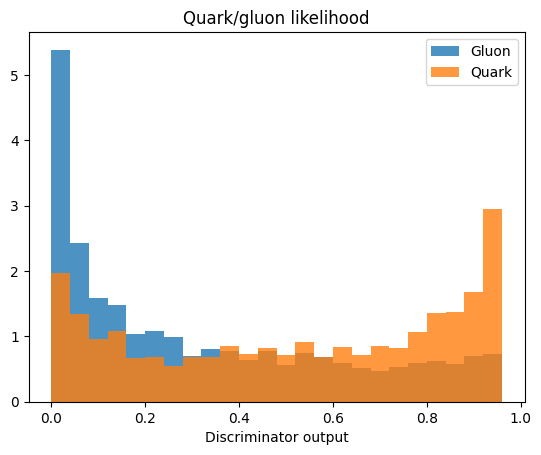

In [43]:
plt.clf()
binning = np.arange(0.0, 1.0, 0.04)

plt.hist(
    ak.flatten(arrays['Jet_qgl'][ak.where(arrays['Jet_isG'], True, False)]), 
    bins=binning, alpha=0.8, label='Gluon', density=1 )

plt.hist(
    ak.flatten(arrays['Jet_qgl'][ak.where(arrays['Jet_isUDS'], True, False)]), 
    bins=binning, alpha=0.8, label='Quark', density=1 )

plt.legend()

plt.xlabel('Discriminator output')
plt.title('Quark/gluon likelihood');

Let's make some selections:

* nJets >= 3
* jet_pt > 30 GeV
* abs(jet_eta) < 2.5

In [35]:
njet_cut = ak.where(
    ak.num(arrays['Jet_pt']) >= 3,
    True, False
) 

arrays = arrays[njet_cut]

pt_cut = ak.all(arrays['Jet_pt'] > 30, axis=1)
eta_cut = ak.all(np.abs(arrays['Jet_eta']) < 2.5, axis=1)

arrays = arrays[pt_cut & eta_cut]

Text(0.5, 0, 'jet_eta')

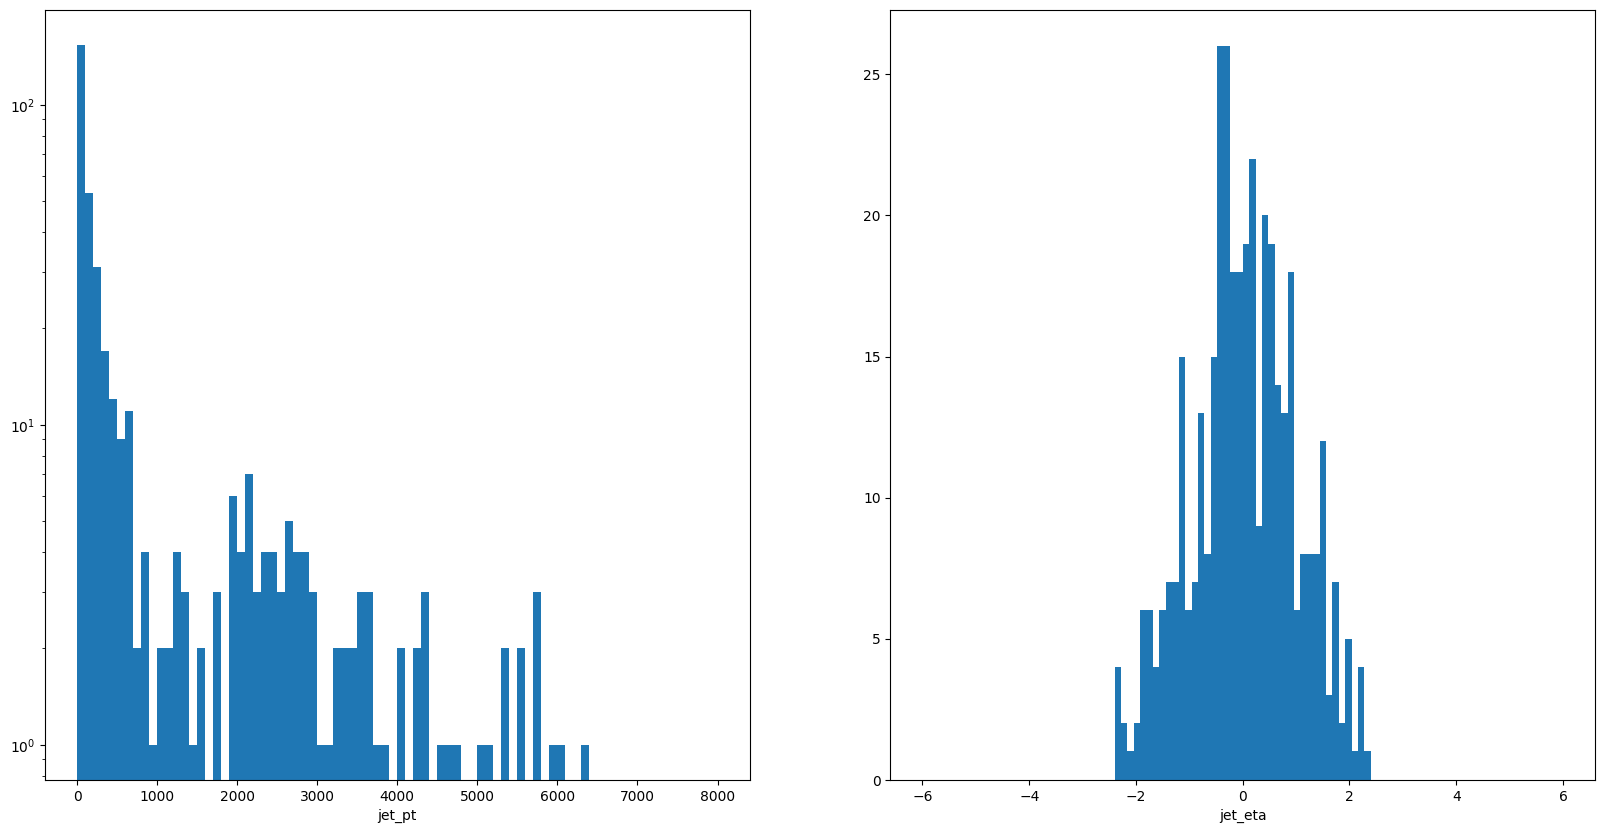

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))

axes[0].hist(ak.flatten(arrays['Jet_pt']), bins=80, range=(0,8000))
axes[0].set_xlabel('jet_pt')
axes[0].set_yscale('log')

axes[1].hist(ak.flatten(arrays['Jet_eta']), bins=100, range=(-6,6))
axes[1].set_xlabel('jet_eta')